Before we start, <font color='red'> PLEASE write your answers at below answer cells  </font> for all questions. <br>
Detailed about questions will be found as you go through the lecture. <br>



####Answer for question 1 (1point):

- Write answer to fill blank OOO in line 18.    

    A:
<font color='white'>14</font>
- Write answer to fill blank OOO in line 22.

    A:
<font color='white'>20</font>

####Answer for question 2 (1point):

*   Which loss function did you use for One hot encoding version?

    A:


####Answer for question 3 (1point):
*  Why do you think LSTM use tanh? <br>
A:
<br>
*  Provide an example scenario where an LSTM would be more appropriate than a basic RNN. <br>
A:

####Answer for question 4 (1point):
- Write your code for update_gate function.
    
    A:


#Tutorial 6: RNN

**Course Title**: AI project (SWE3032-41)

**Acknowledgement** This tutorial is based on the book "PyTorch로 시작하는 딥 러닝 입문" and theaisummer's github.

Welcome to our Recurrent Neural Network tutorial. The following notebook is meant to give an experience of coding on RNN and following topics including naive RNN, LSTM, and GRU.

**Why use RNN?** RNN can handle various tasks (Next step prediction, Classification, Sequence Generation) by using sequential data(Speech, Text, Image).

**There are 4 types of processes:**

![](https://drive.google.com/uc?export=view&id=1MWoJvRqvvpGLdy3ngMYEbOJCtaVWY9dp)

**Today, we implement below models**

1. Text generation.
2. Signal prediction.

We will use a set of standard libraries, which you have already been using throughout previous lectures.

In [ ]:
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import random
import torch
import math
import random
import warnings
warnings.filterwarnings(action='ignore')

**Set SEED**

Below code is to set seed for code. I recommend you to set seed for your project for stable result. However, try not to use "torch.backends.cudnn.deterministic" function from the start because it may slow down calculation.



In [ ]:
seed = 2023
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
# torch.backends.cudnn.deterministic = True

##1. Word-RNN(Recurrent Neural Network)

####Let's implement RNN to text generation!

Task: Sequential Generation

Data: Text

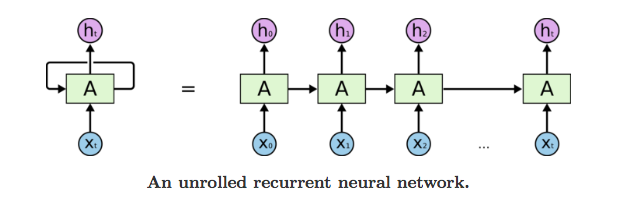

First step to everthing is always data preprocessing!

Note this tutorial don't go through natural language's preprocessing steps such as lemmatization for I wil be using a simple sentence written in standard english. Try tutorial [lemmatization](https://wikidocs.net/21707) if you are not familiar with natural language. Also here is torchtext preprocessing tutorial [Torchtext preprocesing](https://wikidocs.net/60314) could be useful.

###1-1. Data preprocessing

Let's use simple sentence from the movie "Lion King" as a data. Tokenize manually by using set function.

In [ ]:
sentence = "The past can hurt, but you can either run from it, or learn from it".split() # 과거는 아플 수 있어, 하지만 과거로부터 도망갈 수도 있고 배울 수도 있어 - 라이온킹 명대사
#Make a vokabulary list
vocab = list(set(sentence))
print(vocab)

['can', 'from', 'hurt,', 'learn', 'you', 'either', 'but', 'run', 'past', 'or', 'it,', 'The', 'it']


To use word indexing, create word2index dictionary transfroms that translates word to an index(number).
Will be using this dictionary when creating input for the model.

We also create index2word dictionary by reversing key&value of a word2index dictionary. Will be using this dictionary when converting outcome of a model to natural language.





In [ ]:
word2index = {tkn: i for i, tkn in enumerate(vocab, 1)}
word2index['<unk>']=0
print(word2index)

{'can': 1, 'from': 2, 'hurt,': 3, 'learn': 4, 'you': 5, 'either': 6, 'but': 7, 'run': 8, 'past': 9, 'or': 10, 'it,': 11, 'The': 12, 'it': 13, '<unk>': 0}


In [ ]:
#This dict transfroms index to number(number)
index2word = {v: k for k, v in word2index.items()}
print(index2word)

{1: 'can', 2: 'from', 3: 'hurt,', 4: 'learn', 5: 'you', 6: 'either', 7: 'but', 8: 'run', 9: 'past', 10: 'or', 11: 'it,', 12: 'The', 13: 'it', 0: '<unk>'}


Next step is to slice the sentence into input data(x) and label(y).

let's print x and y and see the result. Notice x is from index 0 to one before the last index and label is from index 1 to the last index.

In [ ]:
#Function to make the input data(X) and the labels(Y)
def build_data(sentence, word2index):
  encoded = [word2index[token] for token in sentence] # transforms word to index
  input_seq, label_seq = encoded[:-1], encoded[1:] # Split the input sequence and label sequence
  input_seq = torch.LongTensor(input_seq).unsqueeze(0)
  label_seq = torch.LongTensor(label_seq).unsqueeze(0)
  return input_seq, label_seq, encoded

In [ ]:
x, y, encoded = build_data(sentence, word2index)

In [ ]:
print(f'sentence: "The past can hurt, but you can either run from it, or learn from it" \nencoded {encoded} \nInput data: {x} \nlabes: {y}')

sentence: "The past can hurt, but you can either run from it, or learn from it" 
encoded [12, 9, 1, 3, 7, 5, 1, 6, 8, 2, 11, 10, 4, 2, 13] 
Input data: tensor([[12,  9,  1,  3,  7,  5,  1,  6,  8,  2, 11, 10,  4,  2]]) 
labes: tensor([[ 9,  1,  3,  7,  5,  1,  6,  8,  2, 11, 10,  4,  2, 13]])


####Word Embedding

In order to handle **text** data, a process of changing word to a numeric value is required. We will give embedding dimension as 5.

In [ ]:
embedding_function = torch.nn.Embedding(num_embeddings=len(word2index), embedding_dim = 5)
embedding_function(x)

tensor([[[-8.7140e-01, -5.6517e-01, -2.1406e-01,  2.1855e+00, -4.1826e-01],
         [ 1.8960e-02,  3.0411e-01, -9.2130e-01,  4.0975e-01, -1.5108e+00],
         [ 1.5963e+00,  4.2280e-01, -6.9397e-01,  9.6718e-01,  1.5569e+00],
         [-1.0496e-01,  7.4267e-01, -1.3397e+00, -3.6486e-01,  2.5399e-01],
         [-2.3249e-01,  3.9579e-01,  8.5357e-01, -4.2040e-01, -1.4516e+00],
         [-2.2086e+00, -1.1256e+00,  2.4818e-02,  1.2566e+00, -9.3699e-01],
         [ 1.5963e+00,  4.2280e-01, -6.9397e-01,  9.6718e-01,  1.5569e+00],
         [ 4.8638e-02,  2.8411e-01, -9.5578e-01,  1.4745e+00,  5.1086e-01],
         [-7.3737e-01, -4.2015e-01,  3.0709e-01, -1.2767e+00,  2.0085e-01],
         [-2.3860e+00,  6.9941e-01, -1.0325e+00, -2.6043e+00,  9.3368e-01],
         [ 1.2057e+00,  1.1098e+00, -3.4484e-01,  3.1837e-01,  1.4627e+00],
         [ 2.9006e-01,  2.5075e+00, -8.9630e-01, -2.2588e+00, -1.4798e-03],
         [-1.4082e+00,  2.8347e-01, -9.3333e-01, -6.2785e-01, -7.5152e-02],
         [-2

###1-2. Implenment the Many-to-Many RNN model
We will give multiple inputs and get multiple outputs sequentially.

 First word "life" will be given at time *t* as an input. Then at time *t+1*, hidden representation of "life" and "is" will be given to RNN layer to create outcome. At the last step, softmax will give probability and create loss by utilising cross entropy.

![](https://drive.google.com/uc?export=view&id=1YWWGMXlsX-7vlsDtMv7tgNQxJOG1R9kx)


Set hyperparameters. These values are yet to go tuning. Try grid search you have learned to improve test score!

In [ ]:
#hyper parameter
vocab_size = len(word2index) # 14
input_size = 5 # embbeding dim
hidden_size = 20 # hidden size of RNN layer
epochs = 200

Below is code for the RNN model. Notice it has same structure with other models (made of init and forward function). Take time to go through the code and dimensions of outcomes.

Please visit official docuement [torch.nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)  to find out more about rnn layer.

#### <font color='red'> Question1: Fill in OO.</font>

There are two OOs. line 18 and line 22. Calculate the **dimension** and fill in OOOs. You have used at the answer cell.

In [ ]:
class RNN_model(torch.nn.Module):
  #vocab_size = size of the using word 14 (decided from original text)
  #hidden_size = size of the RNN's output 20 (hyper-parameter)
  #input size = size of input embedding 5 (decided from previous cell)
  def __init__(self, vocab_size, input_size, hidden_size):
    super(RNN_model, self).__init__()
    #Embedding layer
    self.embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size,embedding_dim=input_size) # give embedding for each word
    #RNN layer
    self.rnn_layer = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True) # RNN(5, 20)
    #linear layer
    self.linear = torch.nn.Linear(hidden_size, vocab_size) # Linear(in_features=20, out_features=14, bias=True)
  def forward(self, x):
    #1. Embedding layer
    #size of the data: (batch_size, length of the sequence) -> (batch_size, lenth of the sequence, dimension of embedding)
    y = self.embedding_layer(x)
    # x: tensor([[10,  1,  3, 11,  2, 12,  3,  8,  4,  5,  7,  9,  6,  5]]) torch.Size([1, 14])
    # QUESTION y: torch.Size([1, OO, 5])
    #2. RNN layer
    #size of the data: (batch_size, length of the sequence, embedding dimension) -> y: (batch_size, length of the sequence, hidden_size), hidden: (num_layer, batch_size, hidden_size)
    y, hidden = self.rnn_layer(y)
    # QUESTION y: torch.Size([1, 14, 20]) hidden: torch.Size([1, 1, OO])
    #3. Linear layer
    #size of the data: (batch_size, length of the sequence, hidden_size) -> (batch_size, length of the sequence, vocab_size)
    y = self.linear(y)
    # y: torch.Size([1, 14, 14])

    #Size of the return value: (batch_size*lenth of the sequence, vocab_size)
    return y.view(-1, y.size(2)) # torch.Size([14, 14])

###1-3. Train the RNN model

This is the final step. If the result is not satisfactory, try change hyperparameters.

In [ ]:
model = RNN_model(vocab_size, input_size, hidden_size)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

This is the function to decode the model result into word.

In [ ]:
decode = lambda y: [index2word.get(x) for x in y]

Let's see the output of the model before training. How bad is it?

In [ ]:
output = model(x)
pred = output.softmax(-1).argmax(-1).tolist()

print(f'The past can hurt, but you can either run from it, or learn from it')
print(f'Result of the rnn model: {" ".join(decode(pred))}')

18 torch.Size([1, 14, 5])
24 torch.Size([1, 14, 20])
The past can hurt, but you can either run from it, or learn from it
Result of the rnn model: The you The The you The you The The you The it, The can


Check out the difference training makes!

In [ ]:
#Training
print(f'The past can hurt, but you can either run from it, or learn from it')
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    output = model(x)
    loss = loss_function(output, y.view(-1))
    loss.backward()
    optimizer.step()
    # Observe the result
    if epoch % 20 == 0:
        print(f"Epoch: {epoch}, Loss: {loss}")
        pred = output.softmax(-1).argmax(-1).tolist()
        print(" ".join(['The']+ decode(pred)))
        print()

The past can hurt, but you can either run from it, or learn from it
18 torch.Size([1, 14, 5])
24 torch.Size([1, 14, 20])
18 torch.Size([1, 14, 5])
24 torch.Size([1, 14, 20])
18 torch.Size([1, 14, 5])
24 torch.Size([1, 14, 20])
18 torch.Size([1, 14, 5])
24 torch.Size([1, 14, 20])
18 torch.Size([1, 14, 5])
24 torch.Size([1, 14, 20])
18 torch.Size([1, 14, 5])
24 torch.Size([1, 14, 20])
18 torch.Size([1, 14, 5])
24 torch.Size([1, 14, 20])
18 torch.Size([1, 14, 5])
24 torch.Size([1, 14, 20])
18 torch.Size([1, 14, 5])
24 torch.Size([1, 14, 20])
18 torch.Size([1, 14, 5])
24 torch.Size([1, 14, 20])
18 torch.Size([1, 14, 5])
24 torch.Size([1, 14, 20])
18 torch.Size([1, 14, 5])
24 torch.Size([1, 14, 20])
18 torch.Size([1, 14, 5])
24 torch.Size([1, 14, 20])
18 torch.Size([1, 14, 5])
24 torch.Size([1, 14, 20])
18 torch.Size([1, 14, 5])
24 torch.Size([1, 14, 20])
18 torch.Size([1, 14, 5])
24 torch.Size([1, 14, 20])
18 torch.Size([1, 14, 5])
24 torch.Size([1, 14, 20])
18 torch.Size([1, 14, 5])
24 to

Let's learn about One hot encoding. One hot encoding is a process of converting categorical data variables so they can be provided to machine learning algorithms to improve predictions. On the previous example, we used label encoding. Below is an example of an one-hot encoding.

![](https://drive.google.com/uc?export=view&id=1olIzP1hy6euCkswbCoR3iSHWqa7KI6JR)


Below is a code for one hot encoding.

As you can see, word "you" has index 14 and thus the corresponding one hot vector is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]. Only has "1" at index 12

In [ ]:
def one_hot_encoding(word, word_to_index):
  one_hot_vector = [0]*(len(word_to_index))
  index = word_to_index[word]
  one_hot_vector[index] = 1
  return one_hot_vector
print('word to index dictionary', word2index)
print('one hot encoding of word "you":',one_hot_encoding('you', word2index))

word to index dictionary {'can': 1, 'from': 2, 'hurt,': 3, 'learn': 4, 'you': 5, 'either': 6, 'but': 7, 'run': 8, 'past': 9, 'or': 10, 'it,': 11, 'The': 12, 'it': 13, '<unk>': 0}
one hot encoding of word "you": [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


#### <font color='red'> Question2: Implement one hot encoding.</font>

Implement one hot encoding for the previous example. Complete the code below and write which **loss function** you have used at the answer cell.

In [ ]:
def one_hot_encoding(sentence, word2index):
    encoded = torch.zeros(len(sentence), len(word2index))
    for idx, word in enumerate(sentence):
        word_index = word2index[word]
        encoded[idx][word_index] = torch.LongTensor([1])
    input_seq, label_seq = encoded[:-1], encoded[1:] # Split the input sequence and label sequence
    return input_seq.to(torch.long), label_seq.to(torch.long), encoded.to(torch.long)
x, y, encoded = one_hot_encoding(sentence, word2index)
print(f"x{x}, \ny{y}, \nencoded{encoded}")

xtensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 
ytensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       

In [ ]:
#hyper parameter
vocab_size = len(word2index) # 16
input_size = 5 # embbeding dim
hidden_size = 20 # hidden size of RNN layer
epochs = 200
class RNN_model(torch.nn.Module):
  def __init__(self, vocab_size, input_size, hidden_size):
    super(RNN_model, self).__init__()
    self.vocab_size = vocab_size
    self.input_size = input_size
    self.hidden_size = hidden_size
    #Embedding layer
    self.embedding_layer = torch.nn.Linear(vocab_size, input_size)
    #RNN layer
    self.rnn_layer = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=2, batch_first=True)
    #linear layer
    self.linear = torch.nn.Linear(hidden_size, vocab_size)
  def forward(self, x):
    #1. Embedding layer
    y = self.embedding_layer(x.to(torch.float)).reshape(1,x.shape[0],self.input_size)
    y, hidden = self.rnn_layer(y)
    y = self.linear(y)
    return y.view(-1, y.size(2)) # torch.Size([15, 16])
model = RNN_model(vocab_size, input_size, hidden_size)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
print(f'The past can hurt, but you can either run from it, or learn from it')
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    output = model(x)
    loss = loss_function(output, y.float())
    loss.backward()
    optimizer.step()
    # Observe the result
    if epoch % 20 == 0:
        print(f"Epoch: {epoch}, Loss: {loss}")
        pred = output.argmax(-1).tolist()
        print(" ".join(['The']+ decode(pred)))

The past can hurt, but you can either run from it, or learn from it
Epoch: 20, Loss: 0.031009037047624588
The past can hurt, but from can either run from it, or learn from it
Epoch: 40, Loss: 0.010218254290521145
The past can hurt, but you can either run from it, or learn from it
Epoch: 60, Loss: 0.0009650622960180044
The past can hurt, but you can either run from it, or learn from it
Epoch: 80, Loss: 0.00012683730165008456
The past can hurt, but you can either run from it, or learn from it
Epoch: 100, Loss: 0.0007148306467570364
The past can hurt, but you can either run from it, or learn from it
Epoch: 120, Loss: 4.2004445276688784e-05
The past can hurt, but you can either run from it, or learn from it
Epoch: 140, Loss: 2.03747117666353e-06
The past can hurt, but you can either run from it, or learn from it
Epoch: 160, Loss: 7.354242370638531e-07
The past can hurt, but you can either run from it, or learn from it
Epoch: 180, Loss: 5.9273538965953776e-08
The past can hurt, but you can 

##2. Signal prediction by using LSTM
RNN is a powerful tool but has few major problems. One of which is a long term dependency.

**HOW to deal with long term dependency (gradient vanishing issue)?**
can be answered by lstm. Through this tutorial, we will look at lstm code and try writing GRU code.

Make sure you are using GPU. This tutorial takes long time to train.


In [ ]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using device:", DEVICE)
# 안되면 참고
# https://colab.research.google.com/drive/1bVoeYN_NnpO1D69mUMqhEJZX83b2I5xE#scrollTo=pqZIg84qaaDa
# https://theaisummer.com/understanding-lstm/
# https://theaisummer.com/gru/

Using device: cuda


###2-1. Generate synthetic data.

Let's create a sin wave.

In [ ]:
def generate_synthetic_data(freqs=[1.0], ampls=[1.0], T=500, L=501, N=1):
    """
    Generate synthetic sin wave data.
    Args:
    - freqs (list): List of frequencies for the sine waves.
    - ampls (list): List of amplitudes for the sine waves. Must be the same length as freqs.
    - T (int): A scaling factor.
    - L (int): Length of the sine wave.
    - N (int): Number of sine waves.

    Returns:
    - data (torch.Tensor): The generated sine wave data of shape (N, L).
    """
    if len(freqs) != len(ampls):
        raise ValueError("Length of freqs and ampls must be the same")

    x = torch.linspace(0, T, L, dtype=torch.float64).unsqueeze(0).repeat(N, 1)
    data = torch.zeros(N, L, dtype=torch.float64)

    for freq, amp in zip(freqs, ampls):
        data += amp * torch.sin(freq * x)

    return data
data = generate_synthetic_data()
torch.save(data, 'syntheticdata.pt')


Let's see how the data looks like.

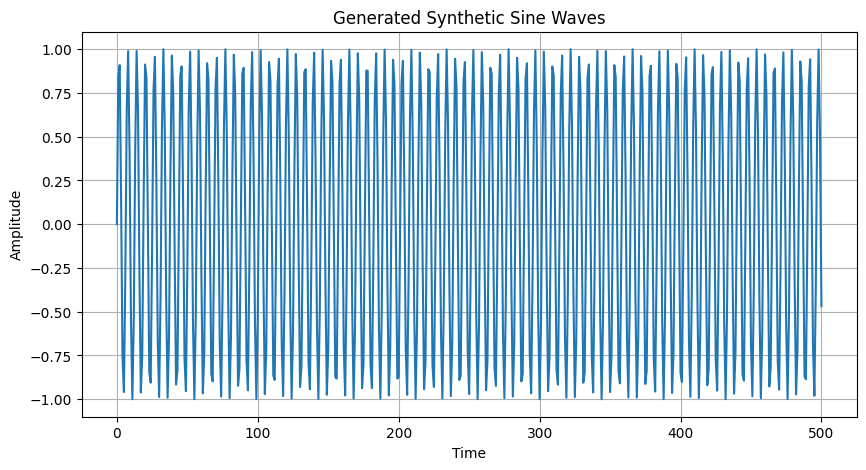

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(data.shape[0]):
    plt.plot(data[i], label=f'Sine wave {i+1}')
plt.title("Generated Synthetic Sine Waves")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

Here is a simple model code.

In [ ]:

class DependencyModel(nn.Module):
    def __init__(self, USE_LSTM=True, USE_CUSTOM=True):
        super(DependencyModel, self).__init__()
        self.LSTM = USE_LSTM
        if USE_LSTM:
            if USE_CUSTOM:
                print("Using custom LSTM model.")
                self.rnn1 = LSTM_custom(1, 151)
                self.rnn2 = LSTM_custom(151, 151)
            else:
                print("Using official PyTorch LSTM cell implementation...")
                self.rnn1 = nn.LSTMCell(1, 151)
                self.rnn2 = nn.LSTMCell(151, 151)
        # GRU
        else:
            if USE_CUSTOM:
                print("Using custom GRU model..")
                self.rnn1 = GRU_custom(1, 151)
                self.rnn2 = GRU_custom(151, 151)
            else:
                print("Using official PyTorch GRU cell implementation...")
                self.rnn1 = nn.GRUCell(1, 151)
                self.rnn2 = nn.GRUCell(151, 151)

        self.linear = nn.Linear(151, 1)

    def forward(self, input, future=0):
        outputs = []
        h_t = torch.zeros(input.size(0), 151, dtype=torch.float64).to('cuda')
        c_t = torch.zeros(input.size(0), 151, dtype=torch.float64).to('cuda')
        h_t2 = torch.zeros(input.size(0), 151, dtype=torch.float64).to('cuda')
        c_t2 = torch.zeros(input.size(0), 151, dtype=torch.float64).to('cuda')

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)): # input을 하나씩 넣기
            if self.LSTM:
                h_t, c_t = self.rnn1(input_t, (h_t, c_t))
                h_t2, c_t2 = self.rnn2(h_t, (h_t2, c_t2))
            else:
                h_t = self.rnn1(input_t, h_t)
                h_t2 = self.rnn2(h_t, h_t2)

            output = self.linear(h_t2)
            outputs += [output]
        # if we should predict the future
        for i in range(future):
            if self.LSTM:
                h_t, c_t = self.rnn1(input_t, (h_t, c_t))
                h_t2, c_t2 = self.rnn2(h_t, (h_t2, c_t2))
            else:
                h_t = self.rnn1(input_t, h_t)
                h_t2 = self.rnn2(h_t, h_t2)
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

Let's run this code, see what it does. Below code trains the synthetic sine data and create the next 5 second's sine wave. Click on "predicted.png" file to check out its outcome.

In [ ]:
data = torch.load('syntheticdata.pt').to('cuda')
input = data[0:1, 0:100].to('cuda')
target = data[0:1, 5:105].to('cuda')
test_input = data[0:1, 105:205].to('cuda')
test_target = data[0:1, 110:210].to('cuda')

seq = DependencyModel(USE_LSTM=True, USE_CUSTOM=False).to('cuda')

seq.double()
criterion = nn.MSELoss()
optimizer = optim.Adam(seq.parameters(), lr=0.01, weight_decay= 1.5e-03)
# begin to train
for i in range(200):
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    with torch.no_grad():
        future = 5
        pred = seq(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        y = pred.detach().cpu().numpy()
# draw the result
plt.figure(figsize=(14, 8))
plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


def draw(yi, color):
    plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth=2.0)
    plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth=2.0)

draw(y[0], 'r')
plt.savefig('predicted.png')
plt.close()

Using official PyTorch LSTM cell implementation...
loss: 0.4997031465264556
loss: 0.5040120258486193
loss: 0.4537050664952369
loss: 0.43597273609648235
loss: 0.3757256969522845
loss: 0.28447000611841133
loss: 0.14481213737915302
loss: 0.049092580467180284
loss: 0.17787933800327024
loss: 0.046961040655007745
loss: 0.024960790729991657
loss: 0.04736215355100176
loss: 0.07159780894976256
loss: 0.06325611389039185
loss: 0.05489483529917667
loss: 0.03369059378792654
loss: 0.025210143986194537
loss: 0.018215504296513602
loss: 0.02644444231446179
loss: 0.033118738877359825
loss: 0.021569005628413934
loss: 0.01530081237705069
loss: 0.015872236504688643
loss: 0.025055838537369465
loss: 0.02804607897564462
loss: 0.025479652061839695
loss: 0.02211231814159262
loss: 0.014411084734027906
loss: 0.011426965948764448
loss: 0.012553013596229113
loss: 0.014709961609969388
loss: 0.012489045589025928
loss: 0.008696474228717827
loss: 0.011275972069078124
loss: 0.014735419802271823
loss: 0.01483853791904723

#### <font color='red'>Question 3: Answer questions below</font>
write your answers at the top of the colab file. <br>
Q: Why do you think LSTM use tanh?

Q: Provide an example scenario where an LSTM would be more appropriate than a basic RNN.

hint1: <font color='white'>Think of 1. What happens to gradient? 2. Can sigmoid decrease value?</font>

hint2: <font color='white'> What is C doing in LSTM? </font>


###2-2. Implement LSTM model and Train that model
In this section, we will take a look at LSTM implementation.
![](https://drive.google.com/uc?export=view&id=1aMPDNrdC5WWp9l5DN_mD86rjYN_xJKC0)


In [ ]:

class LSTM_custom(torch.nn.Module):
    def __init__(self, input_dim=10, hidden_dim=20):
        super(LSTM_custom, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # forget gate components
        self.linear_forget_w1 = nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        self.linear_forget_r1 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=False)
        self.sigmoid_forget = nn.Sigmoid()

        # input gate components
        self.linear_gate_w2 = nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        self.linear_gate_r2 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=False)
        self.sigmoid_gate = nn.Sigmoid()

        # cell memory components
        self.linear_gate_w3 = nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        self.linear_gate_r3 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=False)
        self.activation_gate = nn.Tanh()

        # out gate components
        self.linear_gate_w4 = nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        self.linear_gate_r4 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=False)
        self.sigmoid_hidden_out = nn.Sigmoid()

        self.activation_final = nn.Tanh()

    def forget(self, x, h):
        x = self.linear_forget_w1(x)
        h = self.linear_forget_r1(h)
        return self.sigmoid_forget(x + h)

    def input_gate(self, x, h):
        # Equation 1. input gate
        x_temp = self.linear_gate_w2(x)
        h_temp = self.linear_gate_r2(h)
        i = self.sigmoid_gate(x_temp + h_temp)
        return i

    def cell_memory_gate(self, i, f, x, h, c_prev):
        x = self.linear_gate_w3(x)
        h = self.linear_gate_r3(h)

        # new information part that will be injected in the new context
        k = self.activation_gate(x + h)
        g = k * i

        # forget old context/cell info
        c = f * c_prev
        # learn new context/cell info
        c_next = g + c
        return c_next

    def out_gate(self, x, h):
        x = self.linear_gate_w4(x)
        h = self.linear_gate_r4(h)
        return self.sigmoid_hidden_out(x + h)

    def forward(self, x, tuple_in):
        (h, c_prev) = tuple_in
        # Equation 1. input gate
        i = self.input_gate(x, h)

        # Equation 2. forget gate
        f = self.forget(x, h)

        # Equation 3. updating the cell memory
        c_next = self.cell_memory_gate(i, f, x, h, c_prev)

        # Equation 4. calculate the main output gate
        o = self.out_gate(x, h)

        # Equation 5. produce next hidden output
        h_next = o * self.activation_final(c_next)

        return h_next, c_next

Let's run the custom LSTM cell. Check if its training loss is decreasing normally.

In [ ]:

seq = DependencyModel(USE_LSTM=True, USE_CUSTOM=True).to('cuda')

seq.double()
criterion = nn.MSELoss()
optimizer = optim.Adam(seq.parameters(), lr=0.01, weight_decay= 1.5e-03)
# begin to train
for i in range(20): # 200
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        future = 5
        pred = seq(test_input, future=future)
        # print('pred',pred,pred.shape) # torch.Size([3, 1999])
        loss = criterion(pred[:, :-future], test_target)
        y = pred.detach().cpu().numpy()

Using custom LSTM model.
loss: 0.517102010905202
loss: 0.2668900966854537
loss: 2.6933584067448066
loss: 0.17511760160641868
loss: 0.27770360202306005
loss: 0.30956139521070253
loss: 0.2470049276181242
loss: 0.16372325907513802
loss: 0.0962505577859569
loss: 0.06711087267854693
loss: 0.08240527612173772
loss: 0.06469772740963191
loss: 0.041268556263315874
loss: 0.047068154312328636
loss: 0.0398304472769285
loss: 0.03408656635536723
loss: 0.031194655585708997
loss: 0.026322837095372562
loss: 0.027520348186574898
loss: 0.03079108919877996


### 2-3. GRU Implementation
#### <font color='red'>Question 4: Complete the CODE for GRU (10 points)</font>

please write your answer at the top of the page too.

- Complete the code for update_gate function.
![](https://drive.google.com/uc?export=view&id=10Q943TYoiW2hoT42jSfOWogF0ewrtC8J)
hint:
 <font color='white'>x_reset, h_upd</font>




In [ ]:
class GRU_custom(torch.nn.Module):
    """
    A simple GRU cell network for educational purposes
    """

    def __init__(self, input_dim=10, hidden_dim=20):
        super(GRU_custom, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # reset gate components
        self.linear_reset_w1 = nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        self.linear_reset_r1 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)

        self.linear_reset_w2 = nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        self.linear_reset_r2 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.sigmoid = nn.Sigmoid()

        # update gate components
        self.linear_gate_w3 = nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        self.linear_gate_r3 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)

        self.tanh = nn.Tanh()

    def reset_gate(self, x, h):
        x_1 = self.linear_reset_w1(x)
        h_1 = self.linear_reset_r1(h)
        # gate update
        reset = self.sigmoid(x_1 + h_1)
        return reset

    def update_gate(self, x, h):
        x_2 = self.linear_reset_w2(x)
        h_2 = self.linear_reset_r2(h)
        z = self.sigmoid(h_2 + x_2)
        return z

    def update_component(self, x, h, r):
        x_3 = self.linear_gate_w3(x)
        h_3 = r * self.linear_gate_r3(h)
        gate_update = self.tanh(x_3 + h_3)
        return gate_update

    def forward(self, x, h):
        # Equation 1. reset gate vector
        r = self.reset_gate(x, h)

        # Equation 2: the update gate - the shared update gate vector z
        z = self.update_gate(x, h)

        # Equation 3: The almost output component
        n = self.update_component(x, h, r)

        # Equation 4: the new hidden state
        h_new = (1 - z) * n + z * h

        return h_new

Again check if your implementation decreases the training loss.

In [ ]:

seq = DependencyModel(USE_LSTM=False, USE_CUSTOM=True).to('cuda')

seq.double()
criterion = nn.MSELoss()
optimizer = optim.Adam(seq.parameters(), lr=0.01, weight_decay= 1.5e-03)
# begin to train
for i in range(20):
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        future = 5
        pred = seq(test_input, future=future)
        # print('pred',pred,pred.shape) # torch.Size([3, 1999])
        loss = criterion(pred[:, :-future], test_target)
        y = pred.detach().cpu().numpy()

Using custom GRU model..
loss: 0.6085196955183849
loss: 8.761291826606104
loss: 0.3696105016881066
loss: 0.8795881778317568
loss: 0.2910521537251118
loss: 0.30084557686863805
loss: 0.38411942427504203
loss: 0.23922500427816937
loss: 0.1058823588599632
loss: 0.11934056009884202
loss: 0.14752504563923552
loss: 0.08567633236944269
loss: 0.030862015790337302
loss: 0.06298174688819068
loss: 0.09426196180456307
loss: 0.05816407115975942
loss: 0.024383527215815475
loss: 0.03917760795744719
loss: 0.05870297113727931
loss: 0.04739896515197316


Thank you for listening.